# Credit Card Fraud Detection

# Introducción

La detección de fraude en transacciones con tarjeta de crédito es un problema interesante en el ámbito de la inteligencia artificial aplicada, debido tanto a su impacto económico como a la dificultad del problema. En este tipo de escenarios, los datos suelen estar desbalanceados, ya que las transacciones fraudulentas representan solo una fracción muy pequeña del total, lo que limita la eficacia de muchos métodos de clasificación supervisada.

Una alternativa interesante en este contexto es abordar el problema desde el punto de vista de la detección de anomalías. Bajo este enfoque, el objetivo no es aprender a clasificar entre transacciones legítimas y fraudulentas, sino modelar el comportamiento normal del sistema y detectar aquellas observaciones que se desvían significativamente de dicho patrón. Por lo que se empleará un AutoEncoder para la resolución del problema.

# ¿Qué es un AutoEncoder?

Un AutoEncoder es un modelo de aprendizaje *self supervised* que aprende a reconstruir sus entradas a partir de un espacio latente. Una de sus aplicaciones más relevantes es la detección de anomalías. Esto se debe a que si al AutoEncoder se le entrena con los datos de la clase mayoritaria (comportamiento normal), el modelo es capaz de reconstruir correctamente dichos casos, por lo que la aparición de un comportamiento anomalo será fácil detectarla.  

Como se mencionó previamente, en este proyecto se utilizará un AutoEncoder para detectar transacciones fraudulentas en un conjunto de datos de transacciones reales de tarjetas de crédito. El modelo se entrenará exclusivamente con transacciones no fraudulentas, aprendiendo así una representación adecuada del comportamiento normal. Posteriormente, se utilizará el error de reconstrucción como *anomaly score* para identificar posibles fraudes.

# Librerías

In [32]:
# Dataset y graficos
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesado de datos
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler

# Modelo (AutoEncoder)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Métricas
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Semilla
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Dataset

El conjunto de datos utilizado en este proyecto corresponde a un **dataset de transacciones de tarjetas de crédito realizadas por clientes europeos**, en el cual el objetivo es identificar transacciones fraudulentas. Cada observación representa una transacción individual y está descrita mediante las siguientes variables:

- **V1 – V28:** variables numéricas, que representan distintas características de la transacción como patrones o comportamientos.

- **Amount:** importe de la transacción.

- **Class:** variable binaria que indica si la transacción es fraudulenta (1) o legítima (0).

Una de las características más relevantes de este dataset es su alto grado de desbalanceo. La gran mayoría de las transacciones pertenecen a la clase legítima, mientras que las transacciones fraudulentas constituyen solo un porcentaje muy reducido del total.

Desde el punto de vista de la detección de anomalías, este desbalanceo es adecuado. Las transacciones no fraudulentas pueden interpretarse como el comportamiento normal del sistema, mientras que las transacciones fraudulentas pueden considerarse eventos anómalos. Esta interpretación justifica el uso de un AutoEncoder entrenado exclusivamente con datos normales, tal y como se ha descrito en la sección anterior.

Para el desarrollo del proyecto, el dataset se dividirá en conjuntos de entrenamiento y prueba. El conjunto de entrenamiento estará compuesto únicamente por transacciones no fraudulentas, con el objetivo de que el modelo aprenda una representación del comportamiento normal. El conjunto de prueba, por su parte, incluirá tanto transacciones legítimas como fraudulentas, lo que permitirá evaluar la capacidad del modelo para detectar anomalías mediante el error de reconstrucción.

# Cargar Dataset

In [2]:
# https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
file_path = "/kaggle/input/creditcardfraud/creditcard.csv" 

df = pd.read_csv(file_path)

df.shape

(284807, 31)

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


# Analisis exploratorio del dataset

El análisis exploratorio del conjunto de datos tiene como objetivo comprender la estructura, distribución y características principales de las variables, así como identificar posibles particularidades que puedan influir en el posterior entrenamiento del modelo.

Primero vamos a analizar la distribución de la variable binaria (**Class**), con el fin de cuantificar el grado de desbalanceo existente entre transacciones legítimas y fraudulentas. Este análisis es fundamental para justificar el uso de un enfoque de detección de anomalías, en el cual las transacciones fraudulentas se consideran eventos raros dentro del comportamiento global del sistema.

También vamos a estudiar la distribución de la variable **Amount**, que representa el importe de las transacciones. El análisis de esta variable permite observar la presencia de valores extremos, posibles asimetrías y diferencias entre transacciones normales y fraudulentas.

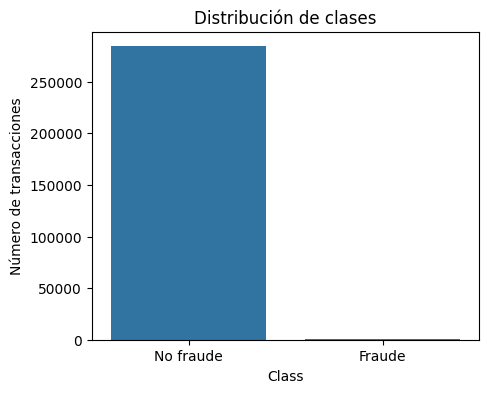

In [6]:
class_counts = df["Class"].value_counts()

plt.figure(figsize=(5, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks([0, 1], ["No fraude", "Fraude"])
plt.ylabel("Número de transacciones")
plt.title("Distribución de clases")
plt.show()

In [7]:
fraud_percentage = 100 * class_counts[1] / class_counts.sum()
fraud_percentage

np.float64(0.1727485630620034)

El porcentaje de transacciones fraudulentas es aproximadamente del **0.17%**, lo que confirma el carácter extremadamente desbalanceado del dataset y justifica el enfoque de detección de anomalías adoptado en este trabajo.

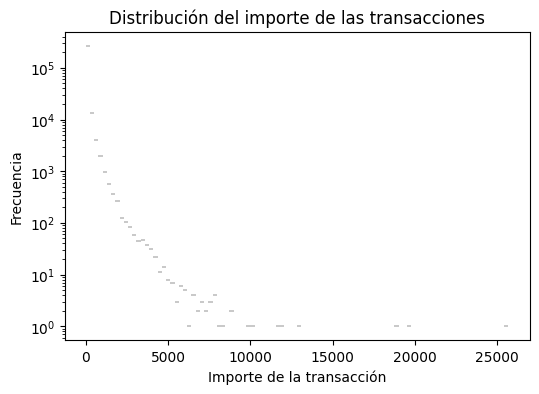

In [8]:
plt.figure(figsize=(6, 4))
sns.histplot(df["Amount"], bins=100, log_scale=(False, True))
plt.xlabel("Importe de la transacción")
plt.ylabel("Frecuencia")
plt.title("Distribución del importe de las transacciones")
plt.show()

La distribución del importe de las transacciones muestra una fuerte asimetría, con una gran concentración de operaciones de bajo importe y una cola de transacciones de alto valor. Esto sugiere la presencia de valores extremos (**outliers**) que podrían influir en el entrenamiento de modelos sensibles a la escala de las variables.

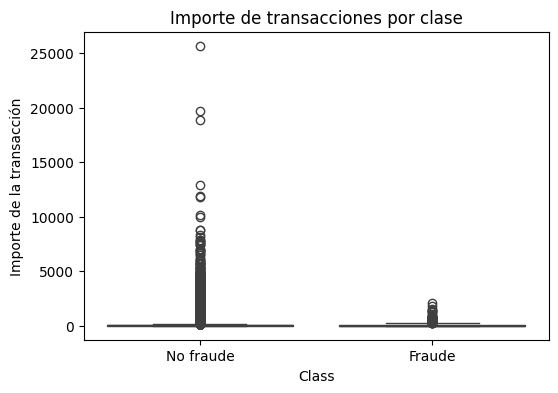

In [9]:
plt.figure(figsize=(6, 4))
sns.boxplot(x="Class", y="Amount", data=df)
plt.xticks([0, 1], ["No fraude", "Fraude"])
plt.ylabel("Importe de la transacción")
plt.title("Importe de transacciones por clase")
plt.show()

Al comparar el importe de las transacciones entre clases, se observa que las operaciones no fraudulentas presentan una mayor variabilidad y un rango de valores más amplio que las transacciones fraudulentas. Estas últimas tienden a concentrarse en importes relativamente bajos, lo que sugiere que el fraude no está necesariamente asociado a importes elevados, sino a patrones complejos de comportamiento. Este resultado sugiere que la detección de fraude no puede abordarse únicamente mediante reglas basadas en el importe de la transacción.

# Preprocesamiento de Datos

Antes de entrenar el modelo de AutoEncoder, es necesario aplicar una serie de pasos de preprocesado con el objetivo de garantizar la estabilidad del entrenamiento y asegurar que los datos se encuentren en un formato adecuado para el aprendizaje no supervisado.

- Primero se separa la variable objetivo (Class) del resto de variables, ya que el AutoEncoder se entrenará sin utilizar etiquetas

- Luego, el conjunto de datos se divide en conjuntos de entrenamiento y prueba. Dado que el objetivo es detectar anomalías, el conjunto de entrenamiento se construye utilizando exclusivamente transacciones no fraudulentas, de manera que el AutoEncoder aprenda una representación compacta del comportamiento normal del sistema.

- Aunque las variables V1-V28 provienen de una transformación por PCA previa, la variable **AMOUNT** presenta una gran asimetría. Por lo tanto aplicamos una normalización de todos los datos con *RobustScaler*. También simplificamos los datos a float32 ya que librerías como TensorFlow/Keras trabajan mejor de esta forma.

- Por último creamos un conjunto de datos de validación a partir de los datos de entrenamiento ya procesados para ajustar hiperparametros del modelo e implementar callbacks durante el entrenamiento.

In [10]:
X = df.drop(columns=["Class"]).copy()
y = df["Class"].copy()

X.shape, y.shape

((284807, 30), (284807,))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((227845, 30), (56962, 30))

In [12]:
X_train_normal = X_train[y_train == 0].copy() # Nos quedamos solo con transacciones normales (Clase 0)
X_test_full = X_test.copy()

X_train_normal.shape, X_test_full.shape

((227451, 30), (56962, 30))

In [13]:
scaler = RobustScaler()

X_train_normal_scaled = scaler.fit_transform(X_train_normal)
X_test_scaled = scaler.transform(X_test_full)

X_train_normal_scaled.shape, X_test_scaled.shape

((227451, 30), (56962, 30))

In [14]:
# float32 (útil para TensorFlow / Keras)
X_train_ae = X_train_normal_scaled.astype(np.float32)
X_test_ae = X_test_scaled.astype(np.float32)

y_test_eval = y_test.values.astype(int)  # etiquetas para evaluación final

X_train_ae.dtype, X_test_ae.dtype, y_test_eval.dtype

(dtype('float32'), dtype('float32'), dtype('int64'))

In [15]:
X_train_ae, X_val_ae = train_test_split(
    X_train_ae,
    test_size=0.2,
    random_state=42
)

X_train_ae.shape, X_val_ae.shape

((181960, 30), (45491, 30))

In [16]:
print("Resumen de particiones:")
print(f"Train total: {X_train.shape}")
print(f"Train normal (para AE): {X_train_normal.shape}")
print(f"Train AE final: {X_train_ae.shape}")
print(f"Val AE (normal): {X_val_ae.shape}")
print(f"Test total (normal + fraude): {X_test_full.shape}")

print("\nDistribución de clases en test:")
unique, counts = np.unique(y_test_eval, return_counts=True)
print(dict(zip(unique, counts)))

Resumen de particiones:
Train total: (227845, 30)
Train normal (para AE): (227451, 30)
Train AE final: (181960, 30)
Val AE (normal): (45491, 30)
Test total (normal + fraude): (56962, 30)

Distribución de clases en test:
{np.int64(0): np.int64(56864), np.int64(1): np.int64(98)}


# Modelo (AutoEncoder)

En esta sección se define y entrena el modelo de AutoEncoder utilizado para la detección de anomalías. La arquitectura seleccionada consta de varias capas densas simétricas en el codificador y decodificador, con un espacio latente de baja dimensionalidad. 

Para evitar sobreajuste y mejorar la generalización, se emplea un conjunto de validación junto con mecanismos de early stopping (*callbacks*) durante el entrenamiento.

In [17]:
n_features = X_train_ae.shape[1]
latent_dim = 8

inputs = keras.Input(shape=(n_features,))
x = layers.Dense(32, activation="relu")(inputs)
x = layers.Dense(16, activation="relu")(x)
latent = layers.Dense(latent_dim, activation="relu", name="latent")(x)

x = layers.Dense(16, activation="relu")(latent)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(n_features, activation="linear")(x)

ae = keras.Model(inputs, outputs, name="AE")
ae.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")

ae.summary()

I0000 00:00:1767813603.825660      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "AE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 30)             │           990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,334 (13.02 KB)

 Trainable params: 3,334 (13.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
]

history_simple = ae.fit(
    X_train_ae, X_train_ae,
    validation_data=(X_val_ae, X_val_ae),
    epochs=50,
    batch_size=256,
    shuffle=True,
    callbacks=callbacks,
    verbose=0
)

# Test

Una vez entrenado el AutoEncoder, se evalúa su comportamiento sobre el conjunto de prueba. Dado que el modelo no produce directamente una predicción de clase, la detección de anomalías se basa en el error de reconstrucción, que se utiliza como anomaly score.

Este enfoque permite transformar el problema de detección de fraude en un problema de *ranking de anomalías*, donde las transacciones con mayor error de reconstrucción son consideradas más sospechosas.

In [19]:
def reconstruction_errors(model, X):
    X_pred = model.predict(X, verbose=0)
    return np.mean(np.square(X - X_pred), axis=1)

scores_test = reconstruction_errors(ae, X_test_ae)
scores_test.shape

(56962,)

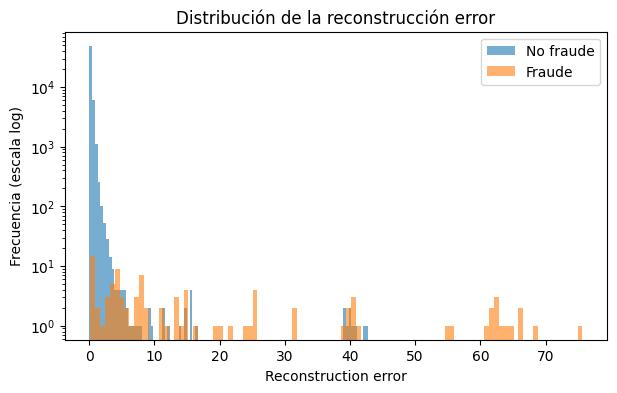

In [25]:
scores_normal = scores_test[y_test_eval == 0]
scores_fraud  = scores_test[y_test_eval == 1]

plt.figure(figsize=(7, 4))
plt.hist(scores_normal, bins=100, alpha=0.6, label="No fraude")
plt.hist(scores_fraud, bins=100, alpha=0.6, label="Fraude")
plt.yscale("log")
plt.xlabel("Reconstruction error")
plt.ylabel("Frecuencia (escala log)")
plt.title("Distribución de la reconstrucción error")
plt.legend()
plt.show()

Se observa que la gran mayoría de las transacciones no fraudulentas presentan errores de reconstrucción muy bajos, concentrados cerca del origen. Esto indica que el AutoEncoder ha aprendido adecuadamente el comportamiento normal del sistema.

Por el contrario, las transacciones fraudulentas tienden a mostrar errores de reconstrucción mayores y una distribución más dispersa, lo que valida el uso de este error como *anomaly score*.

# Métricas

La evaluación del modelo se realiza utilizando métricas adecuadas para escenarios de clases altamente desbalanceadas. En este contexto, la métrica de accuracy no resulta informativa, ya que un clasificador que predijera siempre la clase mayoritaria obtendría un valor elevado sin detectar ningún fraude.

Por este motivo, se emplean métricas basadas en curvas:

- **Precision–Recall (PR)**: Se basa en la precisión de las detecciones positivas y penaliza los falsos positivos.

- **ROC**: Evalua la capacidad del modelo de ordenar correctamente las transacciones según su nivel de anomalía.

El área bajo la curva Precision–Recall (PR-AUC) se utiliza como métrica principal de rendimiento, ya que proporciona una evaluación más realista del comportamiento del modelo en presencia de un fuerte desbalanceo entre clases. A partir del *anomaly score* obtenido, se calculan las curvas PR y ROC para cuantificar de forma objetiva la capacidad del AutoEncoder para detectar transacciones fraudulentas.

In [26]:
# PR curve
precision, recall, thresholds_pr = precision_recall_curve(y_test_eval, scores_test)

pr_auc = average_precision_score(y_test_eval, scores_test)
pr_auc

np.float64(0.6175738729341542)

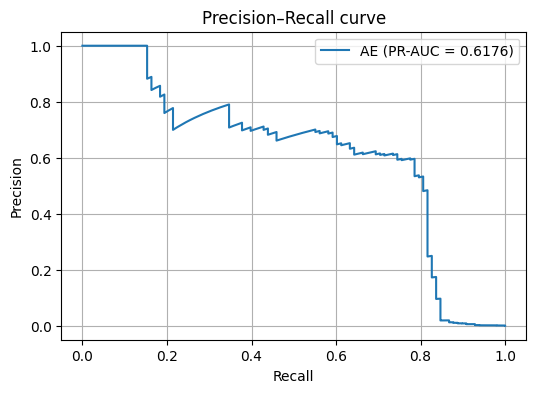

In [22]:
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"AE (PR-AUC = {pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curve")
plt.legend()
plt.grid(True)
plt.show()

El área bajo la curva PR (PR-AUC = 0.62) confirma que el AutoEncoder es capaz de identificar fraudes de manera significativamente mejor que una estrategia aleatoria (baseline = 0.017 para este dataset)

In [23]:
fpr, tpr, thresholds_roc = roc_curve(y_test_eval, scores_test)
roc_auc = roc_auc_score(y_test_eval, scores_test)

roc_auc

np.float64(0.9492229221457857)

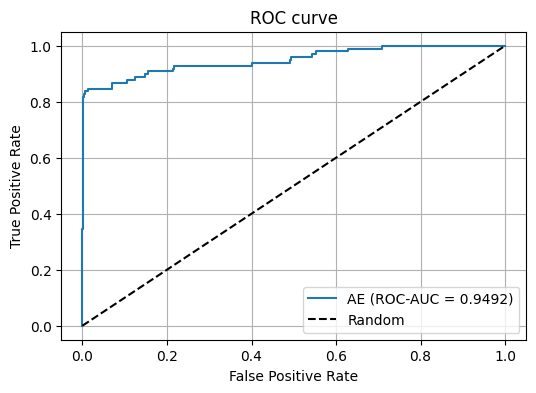

In [24]:
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AE (ROC-AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.grid(True)
plt.show()

La curva ROC muestra la capacidad del modelo para discriminar entre transacciones fraudulentas y legítimas a distintos niveles de umbral. Se observa que la curva se mantiene claramente por encima de la diagonal correspondiente a un clasificador aleatorio, lo que indica una buena capacidad de separación entre clases.

# Umbral de Decisión
El AutoEncoder produce, para cada transacción, un *anomaly score* basado en el error de reconstrucción. Para convertir este valor continuo en una decisión binaria (fraude / no fraude), es necesario definir un umbral de decisión a partir del cual una transacción se considera fraudulenta.

En este proyecto, el umbral se selecciona a partir de la curva Precision–Recall, buscando un equilibrio razonable entre ambas métricas, con el objetivo de minimizar falsos positivos sin dejar de detectar un número significativo de transacciones fraudulentas.

In [28]:
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds_pr[best_idx]

best_threshold

np.float32(3.5558212)

In [29]:
precision[best_idx], recall[best_idx], f1_scores[best_idx]

(np.float64(0.5968992248062015),
 np.float64(0.7857142857142857),
 np.float64(0.6784140920095479))

Este resultado indica que, bajo este umbral, el modelo es capaz de detectar aproximadamente el **79%** de las transacciones fraudulentas, manteniendo al mismo tiempo una precisión cercana al **60%**, lo que implica que una parte de las alertas generadas corresponden a fraudes reales.

# Matriz de Confusión
Una vez seleccionado el umbral de decisión, se clasifican las transacciones del conjunto de prueba comparando su error de reconstrucción con dicho umbral. Las transacciones cuyo *anomaly score* supera el umbral se consideran fraudulentas.

Para evaluar el comportamiento del modelo bajo este criterio, se emplea la matriz de confusión, que permite analizar de forma detallada los siguientes casos:

- Verdaderos positivos (fraudes correctamente detectados)

- Falsos positivos (transacciones legítimas clasificadas como fraude)

- Verdaderos negativos (transacciones legítimas correctamente identificadas)

- Falsos negativos (fraudes no detectados)

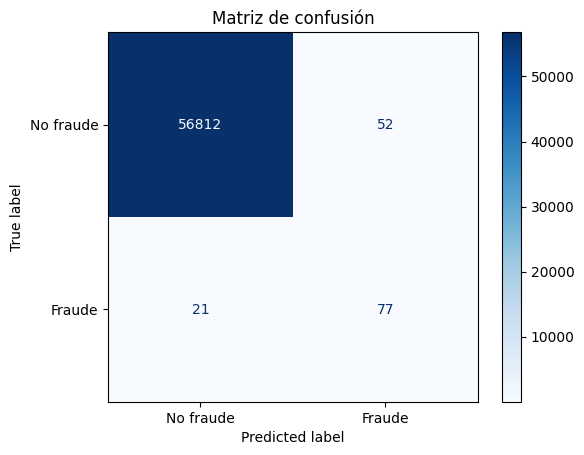

In [31]:
y_pred = (scores_test >= best_threshold).astype(int)

cm = confusion_matrix(y_test_eval, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No fraude", "Fraude"])
disp.plot(cmap="Blues")
plt.title("Matriz de confusión")
plt.show()

La matriz de confusión obtenida al aplicar el umbral seleccionado permite analizar el comportamiento del modelo:

**Verdaderos negativos (TN = 56 812)**: la gran mayoría de las transacciones legítimas son correctamente identificadas como no fraudulentas.

**Verdaderos positivos (TP = 77)**: una proporción relevante de las transacciones fraudulentas es detectada correctamente.

**Falsos positivos (FP = 52)**: algunas transacciones legítimas son clasificadas erróneamente como fraude, lo que podría traducirse en revisiones manuales innecesarias o confrontaciones con el cliente.

**Falsos negativos (FN = 21)**: un número reducido de fraudes no es detectado por el sistema, lo que representa un riesgo económico potencial.

# Conclusiones
En este proyecto se ha abordado el problema de la detección de fraude en transacciones con tarjeta de crédito desde un enfoque de **detección de anomalías**, utilizando un modelo de AutoEncoder entrenado exclusivamente con transacciones legítimas.

A través del análisis exploratorio de los datos se confirmó el fuerte desbalanceo entre clases y la presencia de patrones complejos que no pueden capturarse mediante reglas simples basadas únicamente en el importe de la transacción. El preprocesamiento aplicado permitió estabilizar el entrenamiento del modelo y adaptar los datos al contexto de aprendizaje no supervisado.

Los resultados obtenidos muestran que el AutoEncoder es capaz de aprender una representación efectiva del comportamiento normal del sistema, produciendo errores de reconstrucción bajos para transacciones legítimas y significativamente mayores para transacciones fraudulentas. La evaluación mediante métricas adecuadas para datos desbalanceados, como la curva Precision–Recall, confirma que el modelo supera el rendimiento esperado de un clasificador aleatorio.

En conclusión, este proyecto demuestra que los AutoEncoders son una herramienta eficaz para la detección de fraude, especialmente en contextos donde las etiquetas son escasas o muy desbalanceadas.